# Projet Lamarmite - Exploration des données

## Initialisation

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import os
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from sklearn import linear_model
import warnings

pd.options.display.float_format = '{:,.3f}'.format
input_file = 'off.csv'
plot_size = (14, 4)

## Chargement

In [2]:
data = pd.read_csv(input_file, delimiter='\t', dtype={'code': object})

In [3]:
print(data.info(memory_usage='deep')) # infos sur les données chargées

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91142 entries, 0 to 91141
Data columns (total 56 columns):
code                           91142 non-null object
product_name                   91142 non-null object
brands_tags                    85293 non-null object
labels_tags                    34896 non-null object
additives_n                    53338 non-null float64
ingredients_from_palm_oil_n    53338 non-null float64
nutrition_grade_fr             60973 non-null object
main_category                  61410 non-null object
energy_100g                    64117 non-null float64
energy-from-fat_100g           30 non-null float64
fat_100g                       47217 non-null float64
saturated-fat_100g             61922 non-null float64
monounsaturated-fat_100g       1176 non-null float64
polyunsaturated-fat_100g       1194 non-null float64
omega-3-fat_100g               650 non-null float64
trans-fat_100g                 364 non-null float64
cholesterol_100g               388 non-nul

In [4]:
missing_values = data.isnull().sum(axis=0).to_frame(name='count_missing') # nb de valeurs manquantes
missing_values.sort_values(by=['count_missing'], inplace=True) 
missing_values['percent_missing'] = missing_values['count_missing'] / len(data) * 100 # calcul du %
print(", ".join([f"{idx} ({row['percent_missing']:0.1f}%)" for idx, row in missing_values.iterrows()]))

code (0.0%), product_name (0.0%), main_brand (6.4%), brands_tags (6.4%), energy_100g (29.7%), proteins_100g (30.0%), salt_100g (31.9%), sodium_100g (31.9%), sugars_100g (31.9%), saturated-fat_100g (32.1%), main_category (32.6%), nutrition_grade_fr (33.1%), nutrition-score-fr_100g (33.1%), nutrition-score-uk_100g (33.1%), additives_n (41.5%), ingredients_from_palm_oil_n (41.5%), fat_100g (48.2%), carbohydrates_100g (48.7%), fiber_100g (50.2%), labels_tags (61.7%), fruits-vegetables-nuts_100g (96.7%), alcohol_100g (97.4%), calcium_100g (97.6%), vitamin-c_100g (98.6%), polyunsaturated-fat_100g (98.7%), monounsaturated-fat_100g (98.7%), iron_100g (98.7%), vitamin-b1_100g (99.1%), magnesium_100g (99.1%), vitamin-e_100g (99.1%), vitamin-b6_100g (99.2%), vitamin-pp_100g (99.2%), vitamin-b9_100g (99.2%), cocoa_100g (99.3%), omega-3-fat_100g (99.3%), vitamin-b2_100g (99.3%), vitamin-d_100g (99.4%), vitamin-a_100g (99.4%), phosphorus_100g (99.4%), vitamin-b12_100g (99.4%), pantothenic-acid_100g 

La plupart des colonnes contiennent des valeurs manquantes. Nous faisons le choix de ne pas intervenir et de conserver "un gruyère", en effet :
- effacer toute ligne dans laquelle au moins une valeur est manquante nous priverait de trop de données ;
- estimer les valeurs manquantes nécessiterait une expertise ou un accès à des données supplémentaires que nous n'avons pas.

Avant toute analyse, nous devrons donc nous assurer que les lacunes dans données ne créent pas de problème, et le cas échéant (par exclusion probablement, à confirmer au cas pas cas).

## Recommandation d'approche initiale

Pour un prototype ou un produit minimum viable, on pourra sélectionner les produits en fonction de leur Nutri-score (attribut `nutrition_grade_fr`) qui résume en une seule valeur la qualité nutritionnelle.

Cette méthode présente l'avantage de la simplicité, puisqu'aucun calcul ni modèle ne sont nécessaires. Toutefois il faut également en conserver les limites à l'esprit, notamment :
- pour environ un tiers des produits le Nutri-Score n'est pas disponible ;
- nous ne pourrons pas modifier la formule de calcul, celle-ci n'étant paramétrable, par exemple pour utiliser une pondération différente, ou pour en corriger les défauts.

Ce dernier point est important, car, bien que la notation Nutri-score ait le mérite d'exister, elle présente des lacunes qui sont la contrepartie de sa simplicité, par exemple :
- les additifs alimentaires ne sont pas pris en compte ;
- un fort degré de transformation des aliments n'est pas pénalisé, alors que la nocivité des aliments ultra-transformés est désormais bien établie ;
- pire, le Nutri-score favorise les produits ultra-transformés par rapport à des produits simples et de bonne qualité : voir un exemple typique ci-dessous ;
- les industriels peuvent en modifiant légèrement la composition de leurs produits améliorer artificiellement leurs notes.

Il est donc très probable que le client ressente assez rapidement le besoin de mettre en place son propre système de notation, soit en complément, soit en remplacement du Nutri-score.


### Exemple d'incohérence du Nutri-score

In [5]:
for product in['100 % Pur fruit pressé, jus de pomme bio', 'Coca-Cola zero']:
    row = data[data.product_name == product].index[0]
    print(f"Le produit '{product.lower()}' a pour Nutri-score : {data.at[row, 'nutrition_grade_fr']}")

Le produit '100 % pur fruit pressé, jus de pomme bio' a pour Nutri-score : C
Le produit 'coca-cola zero' a pour Nutri-score : B


<table><tr style="background-color: #fff">
    <td><img src="https://static.openfoodfacts.org/images/products/356/007/082/0597/front_fr.38.400.jpg"></td>
    <td><img src="https://static.openfoodfacts.org/images/products/544/900/013/1843/front_fr.46.400.jpg"></td>
    </tr><tr>    
    <td><img src="https://static.openfoodfacts.org/images/misc/nutriscore-c.svg"></td>    
    <td><img src="https://static.openfoodfacts.org/images/misc/nutriscore-b.svg"></td>
</tr></table>    

### Distribution du Nutri-Score

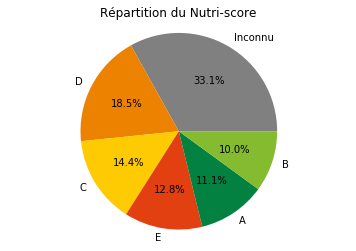

In [6]:
scores = data['nutrition_grade_fr'].replace(to_replace=np.nan, value='Inconnu')
colors = ['gray', '#ED8200', '#FECB02', '#E24010', '#028141', '#85BB2E']
axes = scores.value_counts().plot.pie(autopct='%1.1f%%', colors=colors)
axes.axis('equal');
axes.set_title('Répartition du Nutri-score');
axes.set_ylabel('');


### Comparaison des scores entre produits conventionels et bio

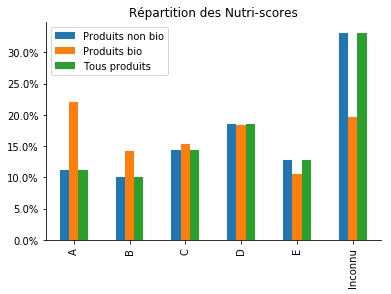

In [7]:
mask = data.labels_tags.str.contains('organic|bio', regex=True).replace(to_replace=np.nan, value=False)
org_scores = scores[mask] # produits bio
conv_scores = scores[~mask] # produits non bio
pct_scores = scores.value_counts() / len(scores) * 100 # % pour tous les produits
pct_conv_scores = conv_scores.value_counts() / len(conv_scores) * 100
pct_org_scores = org_scores.value_counts() / len(org_scores) * 100
agg = pd.DataFrame({'Produits non bio': pct_scores, 
                    'Produits bio': pct_org_scores, 
                    'Tous produits': pct_scores})
axes = agg.plot(kind='bar')
axes.set_title("Répartition des Nutri-scores")
axes.yaxis.set_major_formatter(mtick.PercentFormatter())
sns.despine(ax=axes)

Les produits bio ont 2 fois plus de produits classés A, 40% plus de produits B et 40% moins de produits non classés. Nous vérifions que ce résultat est significatif à l'aide d'un test du $\chi^2$.

In [8]:
# Calculons le tableau de contigence, d'abord sans marges
col1 = org_scores.value_counts().rename('Bio')
col2 = conv_scores.value_counts().rename('Non-bio')
cont_no_margins = pd.concat([col1, col2], axis=1, sort=True)
# 2e tableau avec marges
cont = cont_no_margins.copy()
cont.loc[:, 'Total'] = cont.sum(axis=1)
cont.loc['Total'] = cont.sum(axis=0)
cont 

,Bio,Non-bio,Total
A,2504,7648,10152
B,1623,7516,9139
C,1742,11359,13101
D,2087,14792,16879
E,1198,10504,11702
Inconnu,2236,27933,30169
Total,11390,79752,91142


Si la qualité nutritionnelle et la présence d'une certification bio étaient indépendantes, on aurait le tableau de contingence suivant :

In [9]:
t1 = cont[['Total']][0:-1]
t2 = cont.iloc[-1, :-1]
ind_cont = t1.dot(t2.to_frame().T) / cont.at['Total', 'Total'] # tableau d'indépendance
ind_cont

,Bio,Non-bio
A,"1,268.694","8,883.306"
B,"1,142.099","7,996.901"
C,"1,637.230","11,463.770"
D,"2,109.366","14,769.634"
E,"1,462.397","10,239.603"
Inconnu,"3,770.215","26,398.785"


Nous calculons maintenant la mesure $d^2$ et sa valeur critique.

In [10]:
p = 0.01
d2_contrib = ((cont_no_margins - ind_cont) ** 2 / ind_cont) # contribution au d2 par case
d2 = d2_contrib.sum().sum()
print(f"d2 = {d2}")
dof = (len(cont_no_margins.index) - 1) * (len(cont_no_margins.columns) - 1)
critical_value = stats.chi2.isf(p, dof)
print(f"Valeur critique à {p*100}% = {critical_value:0.2f}")

d2 = 2382.0338670788633
Valeur critique à 1.0% = 15.09


Interprétation : $d^2$ est une mesure de liaison comprise entre $0$ (en cas d'indépendance) et $n \cdot \inf(s-1, r-1)$. 
Le maximum est atteint en cas de dépendance fonctionnelle. 

$d^2$ étant une réalisation d'une variable suivant une loi $\chi^2_{(r-1)(s-1)}$, on peut effectuer un test statistique : la valeur critique à $1 \%$ d'un $\chi^2_5$ est $15,09$. On peut donc largement rejeter l'hypothèse d'indépendance entre certification bio et qualité nutritive.

Identifions maintenant les cases du tableau de contigence dans lesquelles se manifeste l'écart à l'indépendance :

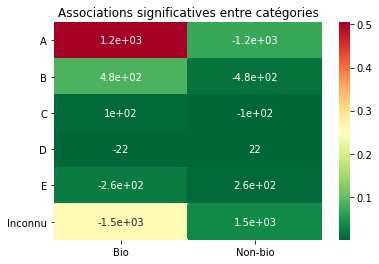

In [11]:
axes = plt.axes()
sns.heatmap(d2_contrib / d2, cmap='RdYlGn_r', ax=axes, annot=cont_no_margins-ind_cont);
axes.set_title('Associations significatives entre catégories');

La valeur dans chaque case représente l'écart (absolu) avec l'effectif théorique en cas d'indépendance.

On voit qu'il existe une association positive et significative entre le fait qu'un produit soit certifié bio et appartienne à la catégorie A. On note également, dans une moindre mesure, une association négative avec l'absence de Nutri-score. 

Les produits bio sont donc plus sains et informent mieux le consommateur.

### Marques pour lesquelles le Nutri-score est fourni

In [12]:
# Nous commençons par déterminer la liste des petites marques, i.e. ayant trop peu de produits.
# Nous les excluons du champ de notre étude, car leur produits seront difficiles à trouver.
min_products = 10
prd_per_brand = data['main_brand'].value_counts()
mask = prd_per_brand >= min_products
tiny_brands = prd_per_brand.loc[~mask].index
print(f"Nous excluons {(~mask).sum()} marques et {prd_per_brand[~mask].sum()} produits.")
print(f"Nous conservons {(mask).sum()} marques et {prd_per_brand[mask].sum()} produits.")

Nous excluons 11853 marques et 21239 produits.
Nous conservons 1130 marques et 64054 produits.


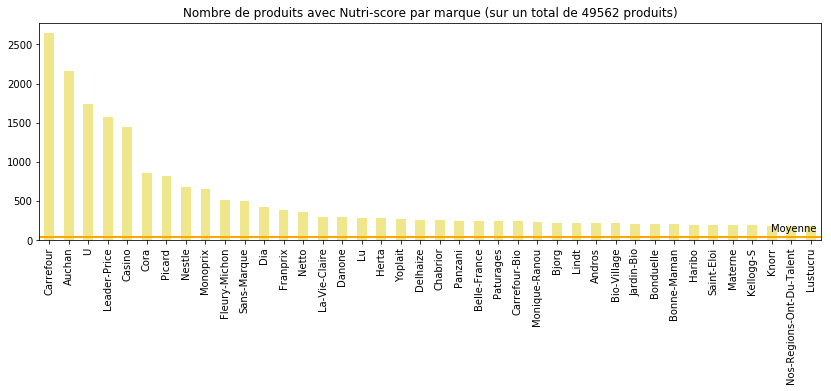

In [13]:
num_rows = 40
mask = data['nutrition_grade_fr'].notnull() & ~data['main_brand'].isin(tiny_brands)
total = mask.sum()
nutriscore_per_brand = data.loc[mask, 'main_brand'].value_counts()
axes = nutriscore_per_brand[0:num_rows].plot.bar(figsize=plot_size, color='khaki')
axes.set_title(f"Nombre de produits avec Nutri-score par marque (sur un total de {total} produits)");
avg = nutriscore_per_brand.sum() / len(nutriscore_per_brand)
axes.axhline(avg, color='orange', linewidth=2); # ligne horizontale de moyenne
axes.annotate("Moyenne", xy=(num_rows-1,avg), xytext=(-40,5), textcoords='offset points');

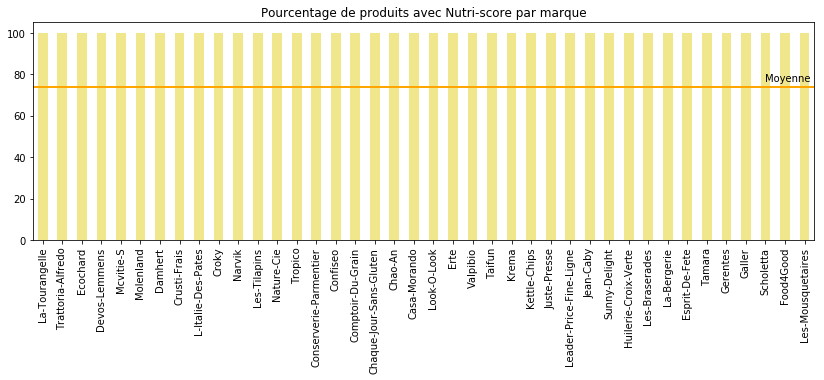

In [14]:
pct_nutriscore_per_brand = nutriscore_per_brand / prd_per_brand * 100 # calcule % de produits
avg = pct_nutriscore_per_brand.mean()
pct_nutriscore_per_brand = pct_nutriscore_per_brand.sort_values(ascending=False) 
axes = pct_nutriscore_per_brand[0:num_rows].plot.bar(figsize=plot_size, color='khaki')
axes.set_title(f"Pourcentage de produits avec Nutri-score par marque");
axes.axhline(avg, color='orange', linewidth=2); # ligne horizontale de moyenne
axes.annotate("Moyenne", xy=(num_rows-1,avg), xytext=(-40,5), textcoords='offset points');

Cette représentation nous fournit une liste de marques avec un haut niveau d'informations nutritives, mais nous dit peu sur la distribution (le pourcentage étant le même pour tous les individus sélectionnés). Nous avons donc recours à un histogramme pour élargir notre vision à toute la population.

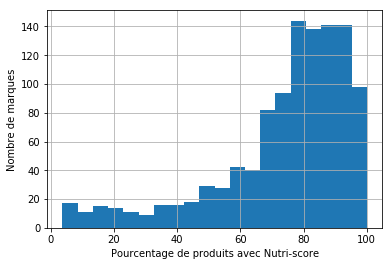

In [15]:
axes = pct_nutriscore_per_brand.hist(bins=20)
axes.set_xlabel('Pourcentage de produits avec Nutri-score')
axes.set_ylabel('Nombre de marques');

### Relation entre marque et valeur du Nutri-score

#### Produits majoritairement de qualité A et B

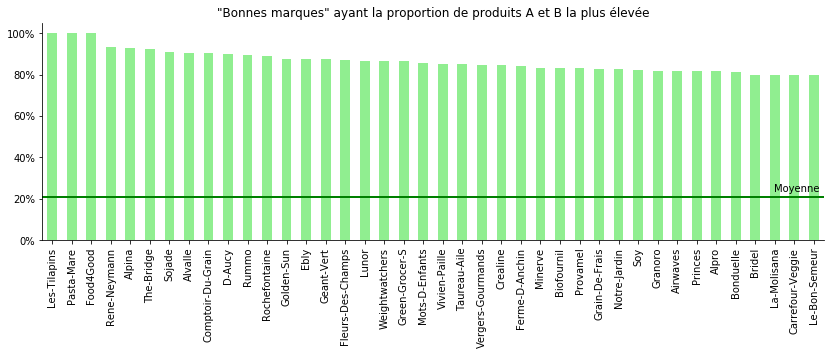

In [16]:
mask = data['nutrition_grade_fr'].isin(['A', 'B']) & ~data['main_brand'].isin(tiny_brands)
ab_per_brand = data.loc[mask, 'main_brand'].value_counts()
pct_ab_per_brand = ab_per_brand / prd_per_brand * 100 # calcule % de produits sur nb total de produits
pct_ab_per_brand = pct_ab_per_brand.dropna().sort_values(ascending=False) 
axes = pct_ab_per_brand.head(num_rows).plot.bar(figsize=plot_size, color='lightgreen')
axes.yaxis.set_major_formatter(mtick.PercentFormatter())
axes.set_title('"Bonnes marques" ayant la proportion de produits A et B la plus élevée');
axes.axhline(ab_per_brand.mean(), color='green', linewidth=2); # ligne horizontale de moyenne
axes.annotate("Moyenne", xy=(num_rows-1,ab_per_brand.mean()), xytext=(-40,5), textcoords='offset points')
sns.despine(ax=axes)

#### Produits majoritairement de qualité D et E

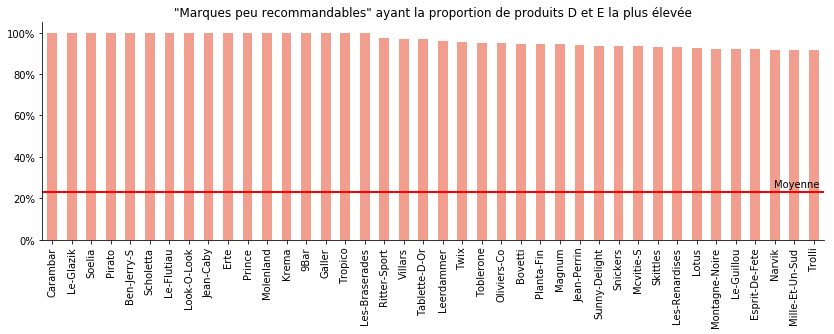

In [17]:
mask = data['nutrition_grade_fr'].isin(['D', 'E']) & ~data['main_brand'].isin(tiny_brands)
ed_per_brand = data.loc[mask, 'main_brand'].value_counts()
pct_ed_per_brand = ed_per_brand / prd_per_brand * 100 # calcule % de produits sur nb total de produits
pct_ed_per_brand = pct_ed_per_brand.dropna().sort_values(ascending=False) 
axes = pct_ed_per_brand.head(num_rows).plot.bar(figsize=plot_size, color='xkcd:blush')
axes.yaxis.set_major_formatter(mtick.PercentFormatter())
axes.set_title('"Marques peu recommandables" ayant la proportion de produits D et E la plus élevée');
axes.axhline(ed_per_brand.mean(), color='red', linewidth=2); # ligne horizontale de moyenne
axes.annotate("Moyenne", xy=(num_rows-1,ed_per_brand.mean()), xytext=(-40,5), textcoords='offset points')
sns.despine(ax=axes)

Encore une fois, ces 2 graphiques nous donnent une liste de marques mais apportent peu d'information sur la forme des distributions, car tous les points sont situés en queue de distribution. Un histogramme nous permettra d'y voir plus clair.

#### Vérification rapide du caractère significatif de ces valeurs

Valeur p = 0.0 pour d2 = 14536.42.


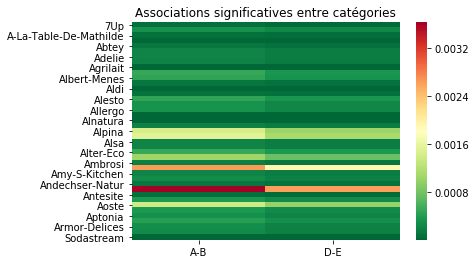

In [18]:
# Tableau de contingence
cont = pd.concat([ab_per_brand.rename('A-B'), ed_per_brand.rename('D-E')], axis=1, sort=True)
cont.replace(to_replace=np.nan, value=0, inplace=True)
# Cette fois-ci nous déléguons les calculs à scipy
d2, p, dof, expected = stats.chi2_contingency(cont)
print(f"Valeur p = {p} pour d2 = {d2:0.2f}.")
ind_cont = pd.DataFrame(data=expected, index=cont.index, columns=cont.columns)
d2_contrib = ((cont - ind_cont) ** 2 / ind_cont) # contribution au d2 par case
top = d2_contrib.head(num_rows)
top = top.append(d2_contrib.loc['Sodastream']) # marque avec une contribution au d2 nulle
axes = plt.axes()
sns.heatmap(top/d2, cmap='RdYlGn_r', ax=axes);
axes.set_title('Associations significatives entre catégories');

Ces résultats ne sont pertinents que si l'on choisit des produits hors de la base de données. Dans le cas contraire, celle-ci représente la population complète et il n'y a pas de test à réaliser.

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


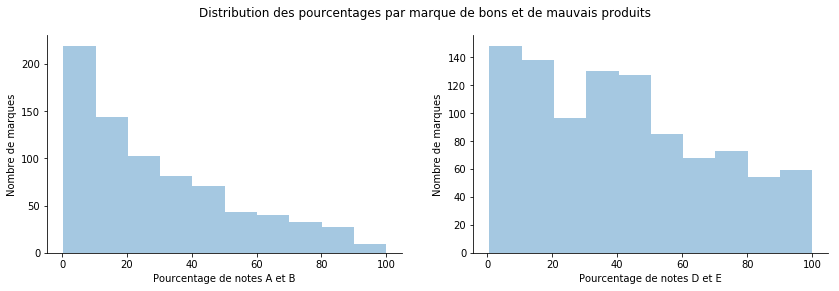

In [19]:
fig, axes = plt.subplots(1, 2, figsize=plot_size)
#pct_ab_per_brand.hist(bins=10, ax=axes[0]);
sns.distplot(a=pct_ab_per_brand, ax=axes[0], kde=False, bins=10)
sns.despine(ax=axes[0])
axes[0].set_xlabel('Pourcentage de notes A et B');
axes[0].set_ylabel('Nombre de marques');
#pct_ed_per_brand.hist(bins=10, ax=axes[1]);
sns.distplot(a=pct_ed_per_brand, ax=axes[1], kde=False, bins=10)
sns.despine(ax=axes[1])
axes[1].set_xlabel('Pourcentage de notes D et E');
axes[1].set_ylabel('Nombre de marques');
fig.suptitle('Distribution des pourcentages par marque de bons et de mauvais produits');

Ces histogrammes nous confirment qu'il y a plus de mauvaises que de bonnes marques, par exemple 2 fois plus de marques avec 80% ou plus de produits de mauvaise qualité (D ou E) que de marques avec 80% ou plus que de bons produits (A ou B).

Nous pouvons donc établir des listes de marques vertueuses, par exemple avec un taux de produits A/B supérieur à 70 %, ou au contraire de marques peu fiables, dont plus de 70 % des produits sont D ou E (ce seuil est donné à titre indicatif). Ces listes nous donnerons des critères simples de sélection, par inclusion et exclusion, lorsque plusieurs produits équivalents existent, et ce même en l'absence de Nutri-score.

In [20]:
threshold = 70
print(f"Nombre de marques recommandables : {sum(ab_per_brand > threshold)}")
print(f"Nombre de marques à éviter : {sum(ed_per_brand > threshold)}")

Nombre de marques recommandables : 44
Nombre de marques à éviter : 51


### Notes `nutrition-score-fr_100g` et `nutrition-score-uk_100g`

#### Comparaison des 2 notes

Nombre de points : 60973


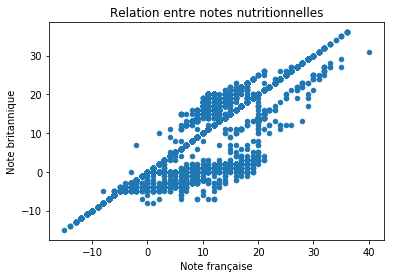

In [21]:
mask = data['nutrition-score-fr_100g'].notnull() & data['nutrition-score-uk_100g'].notnull()
print(f'Nombre de points : {sum(mask)}')
scores = data.loc[mask, ['nutrition-score-fr_100g', 'nutrition-score-uk_100g']]
axes = scores.plot.scatter(x='nutrition-score-fr_100g', y='nutrition-score-uk_100g')
axes.set_xlabel('Note française')
axes.set_ylabel('Note britannique')
axes.set_title('Relation entre notes nutritionnelles');

Ce graphique suggère que les 2 séries sont fortement correlées. Confirmons cette observation en calculant le coefficient de corrélation linéaire.

In [22]:
data_corr = data[['nutrition-score-fr_100g', 'nutrition-score-uk_100g']].dropna()
corr, pval = stats.pearsonr(data_corr['nutrition-score-fr_100g'], data_corr['nutrition-score-uk_100g'])
print(f"Corrélation entre les deux séries = {corr:0.3f}, avec p-value = {pval}.")

Corrélation entre les deux séries = 0.962, avec p-value = 0.0.


Les 2 séries sont donc fortement corrélées, et le niveau de signification (étant inférieur à 1%) nous indique que la corrélation est significative. 

Nous pouvons donc traiter les deux mesures comme équivalentes.

Nous représentons maintenant la droite de régression qui permettrait de prédire, si nécessaire, la note britannique en fonction de la note française.

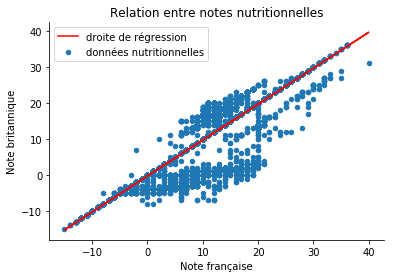

In [23]:
regr = linear_model.LinearRegression()
np_data = np.asarray(data_corr)
regr.fit(np_data[:, 0].reshape(-1, 1), np_data[:, 1])
slope = regr.coef_[0]
intercept = regr.intercept_
axes = scores.plot.scatter(x='nutrition-score-fr_100g', 
                           y='nutrition-score-uk_100g', label='données nutritionnelles')
axes.plot(np_data[:, 0], slope * np_data[:, 0] + intercept, 'r', label='droite de régression')
axes.set_xlabel('Note française')
axes.set_ylabel('Note britannique')
axes.set_title('Relation entre notes nutritionnelles');
axes.legend();
sns.despine(ax=axes)

#### Lien avec le Nutri-score

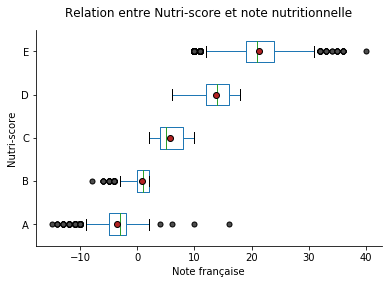

In [24]:
meanprops = {'marker':'o', 'markeredgecolor':'black', 'markerfacecolor':'firebrick'}
mask = data['nutrition_grade_fr'].notnull() & data['nutrition-score-uk_100g'].notnull()
scores = data.loc[mask, ['nutrition_grade_fr', 'nutrition-score-fr_100g']]
fig, axes = plt.subplots(1, 1)
flierprops = {'markerfacecolor': '0.3', 'markersize': 5, 'linestyle':'none'} 
scores.boxplot(column='nutrition-score-fr_100g', by='nutrition_grade_fr', vert=False, ax=axes,
               showmeans=True, meanprops=meanprops, flierprops=flierprops, manage_xticks=True)
axes.set_title('') # supprime le titre auto-généré
axes.set_xlabel('Note française')
axes.set_ylabel('Nutri-score')
fig.suptitle('Relation entre Nutri-score et note nutritionnelle');
axes.grid(False)
sns.despine(ax=axes)

Le passage du Nutri-score à la note nutritionnelle ne respecte pas la relation d'ordre entre produits. Nous renonçons donc à utiliser la note à la place du Nutri-score, car cela entraînerait de nombreuses erreurs de classement.

## Exploration des autres indicateurs pertinents
Parmi les ingrédients restants, nous allons étudier les plus pertinents: 
- Énergie
- Sucres
- Graisses saturées
- Sel
- Nombre d'additifs
- Fibres
- Protéines

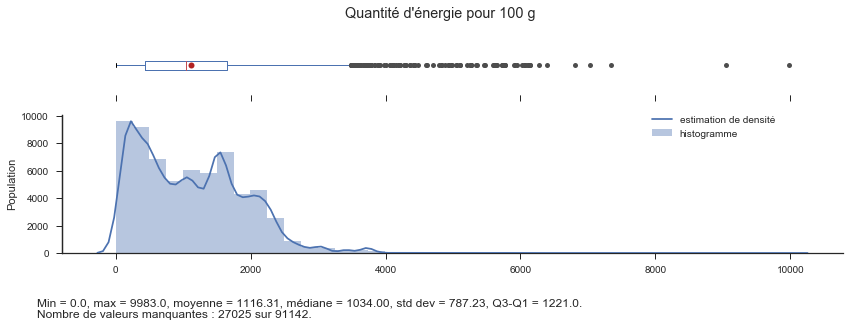

In [25]:
def show_distribution(col_name, bins=None, scale='linear', categories=[], title=''):
    mask1 = ~data[col_name].isnull()
    mask2 = mask1 | ~mask1
    if len(categories) > 0:
        mask2 = data['main_category'].isin(categories)
    s = data.loc[mask1 & mask2, col_name]
    n = len(s)
    sns.set(style="ticks")    
    fig, (axes_box, axes_hist) = plt.subplots(2, 1,  sharex=True, figsize=plot_size,
                                              gridspec_kw={"height_ratios": (.3, .7)})
    # Histogramme
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore') # https://github.com/mwaskom/seaborn/issues/1392
        sns.distplot(a=s, ax=axes_hist, norm_hist=False, kde=False, bins=bins, label='histogramme')
        hidden_axes = axes_hist.twinx() # norm_hist est ignoré, il faut donc tricher
        hidden_axes.set_yticks([]) 
        sns.kdeplot(data=s, label='estimation de densité', ax=hidden_axes) 
        sns.despine(ax=axes_hist)
        sns.despine(ax=hidden_axes, bottom=True)            
        axes_hist.set_xlabel('')        
        axes_hist.set_ylabel('Population')
        axes_hist.legend(loc = (.75,.8), frameon = False) # regroupe les 2 légendes
        hidden_axes.legend( loc = (.75, .9), frameon = False)
    # Boîte à moustaches
    flierprops = {'markerfacecolor': '0.3', 'markersize': 5, 'linestyle':'none'}       
    s.plot(kind='box', ax=axes_box, vert=False, showmeans=True, meanprops=meanprops, flierprops=flierprops)
    axes_box.set_xlabel('')
    # axes_box.set_title('Distribution de ' + col_name)
    axes_box.set_yticks([], []) 
    sns.despine(ax=axes_box, left=True, bottom=True)    
    # Informations supplémentaires
    descr = f"Min = {s.min()}, max = {s.max()}, moyenne = {s.mean():0.2f}, médiane = {s.median():0.2f}, "
    descr = descr + f"std dev = {s.std():0.2f}, Q3-Q1 = {s.quantile(0.75) - s.quantile(0.25)}.\n"
    descr = descr + f"Nombre de valeurs manquantes : {(~mask1 & mask2).sum()} sur {mask2.sum()}."
    fig.text(0.1, -0.1, descr, horizontalalignment='left')
    if len(title) > 0:
        fig.suptitle(title)
    else:
        fig.suptitle('Distribution de ' + col_name)
show_distribution('energy_100g', bins=40, title="Quantité d'énergie pour 100 g") # pour tester

In [26]:
def show_violin_box(col_name, bins=None, scale='linear', categories=[], title=''):
    mask1 = ~data[col_name].isnull()
    mask2 = mask1 | ~mask1
    if len(categories) > 0:
        mask2 = data['main_category'].isin(categories)
    s = data.loc[mask1 & mask2, col_name]
    fig, axes = plt.subplots(1, 1)
    sns.violinplot(y=s, ax=axes, orient='h', inner='quartiles')
    print(f"Minimum = {s.min()}, maximum = {s.max()}, moyenne = {s.mean():0.2f}, médiane = {s.median():0.2f}")
    print(f"Std dev = {s.std():0.2f}, écart interquartile = {s.quantile(0.75) - s.quantile(0.25)}.")
    print(f"Nombre de valeurs manquantes : {(~mask1 & mask2).sum()} sur {mask2.sum()}.")
    if len(title) > 0:
        fig.suptitle(title);      

#show_violin_box('energy_100g')

### Quantité d'énergie

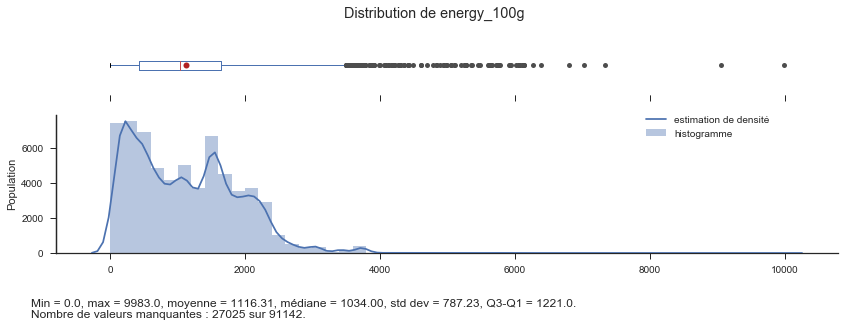

In [27]:
show_distribution('energy_100g')

### Quantité de sucres

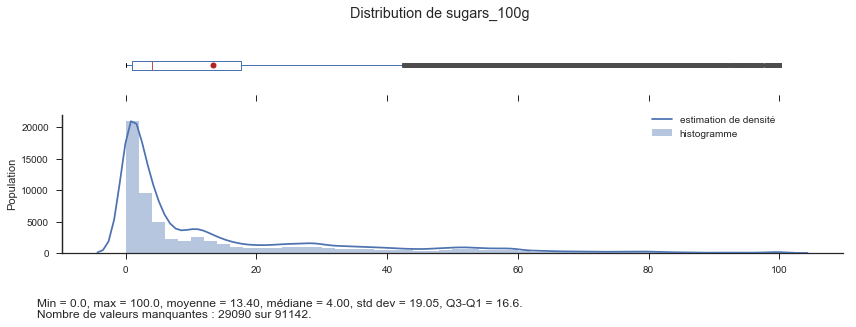

In [28]:
show_distribution('sugars_100g')

### Quantité de graisses saturées

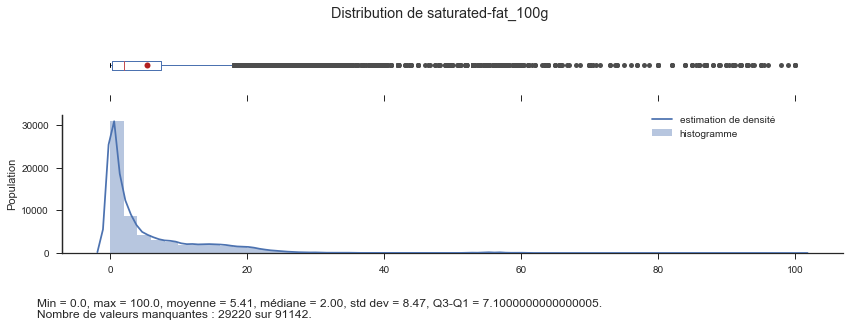

In [29]:
show_distribution('saturated-fat_100g')

### Quantité de sel

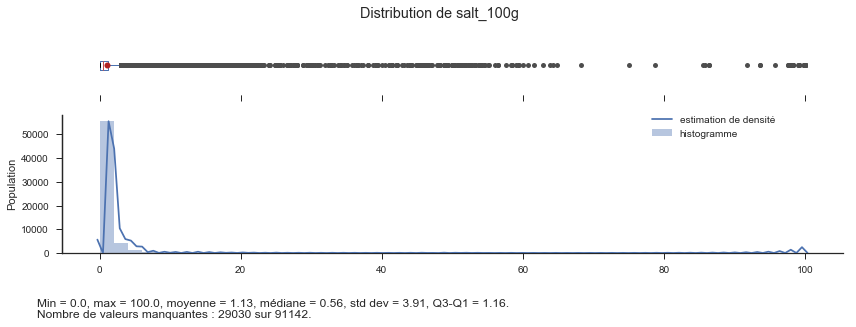

In [30]:
show_distribution('salt_100g')

### Nombre d'additifs

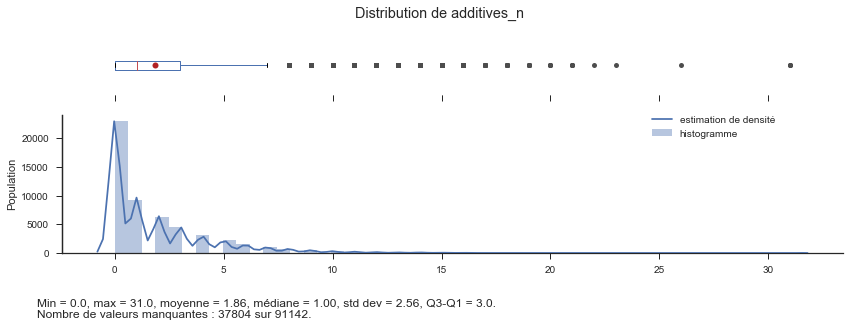

In [31]:
show_distribution('additives_n')

### Quantité de fibres

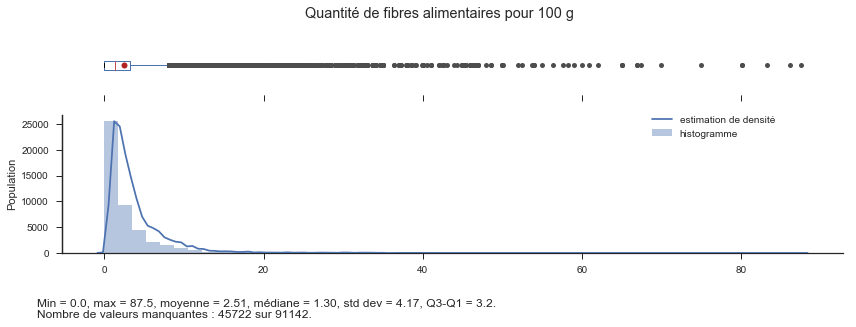

In [32]:
show_distribution('fiber_100g', title='Quantité de fibres alimentaires pour 100 g')

### Quantité de protéines

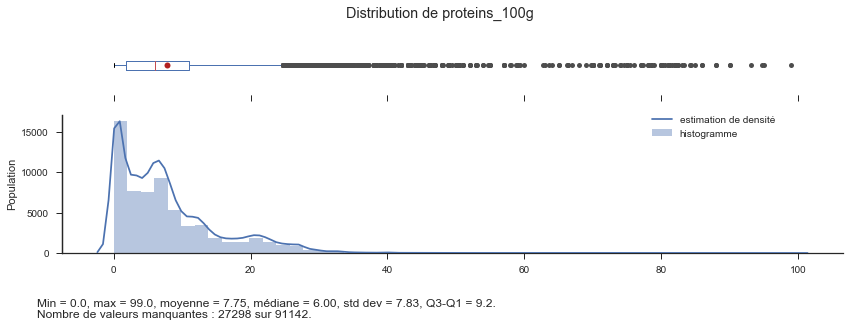

In [33]:
show_distribution('proteins_100g')

Il est difficile et peu pertinent d'essayer d'interpréter ces graphiques, car ils incluent des produits de toutes les catégories, donc ayant des caractéristiques très différentes. Leur principal intérêt est de nous renseigner sur la répartition des valeurs de l'indicateur considéré. 

Nous allons maintenant nous intéresser à quelques distributions sur des sous-ensembles de produits d'un même catégorie.

### Distribution pour des sous-ensembles cohérents de produits

#### Quantité de fibres dans les pâtes alimentaires

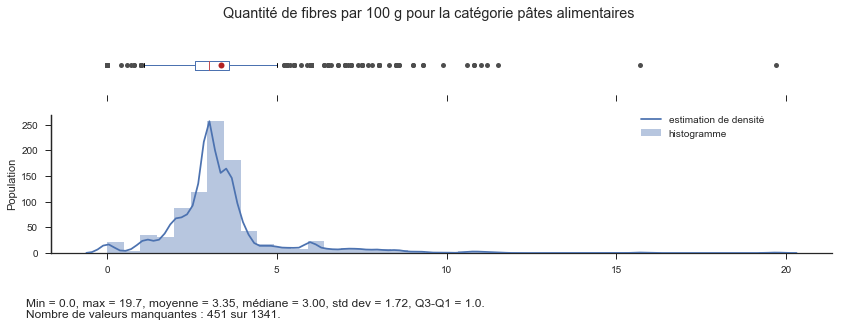

In [34]:
categories = ['fr:pates', 'en:pastas']
show_distribution('fiber_100g', categories=categories, bins=40, 
                  title='Quantité de fibres par 100 g pour la catégorie pâtes alimentaires')

À des fins de modélisation, nous cherchons maintenant à déterminer la loi de probabilité qui décrit le mieux les valeurs observées.

In [35]:
# fonction déterminant la meilleure loi de modélisation de la distribution des données dans `y`
def select_best_dist(y):
    dist_names = ['alpha', 'arcsine', 'beta', 'cauchy', 'chi', 'chi2', 'gamma', 'lognorm', 'norm', 
                  'rayleigh', 't', 'weibull_min', ]
    results = []
    for dist_name in dist_names:
        dist = getattr(stats, dist_name)
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore') # ignore les avertissements de la fonction fit()
            param = dist.fit(y)
        _, p = stats.kstest(y, dist_name, args=param) # test de Kolmogorov-Smirnov
        results.append(p)
        # print(dist_name, p)
    return dist_names[np.argmax(results)]

Meilleure distribution pour modéliser les données : t


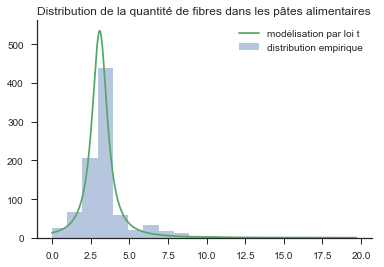

In [36]:
# échantillon à calibrer
mask = data['main_category'].isin(categories) & data['fiber_100g'].notnull()
subset = data.loc[mask, 'fiber_100g']
x = np.linspace(min(subset), max(subset), len(subset))
size = len(subset)
with warnings.catch_warnings():
    warnings.filterwarnings('ignore') # ignore les avertissements de distplot()
    axes = sns.distplot(a=subset, bins=20, kde=False, label='distribution empirique') 
# calibration
dist_name = select_best_dist(subset)
print(f"Meilleure distribution pour modéliser les données : {dist_name}")
# représentation graphique
dist = getattr(stats, dist_name)
with warnings.catch_warnings():
    warnings.filterwarnings('ignore') # ignore les avertissements de la fonction fit()
    param = dist.fit(subset)
pdf_fitted = dist.pdf(x, *param[:-2], loc=param[-2], scale=param[-1]) * size
axes.plot(x, pdf_fitted, label='modélisation par loi ' + dist_name)
axes.set_xlabel('')
axes.legend();
sns.despine(ax=axes) 
axes.set_title('Distribution de la quantité de fibres dans les pâtes alimentaires');

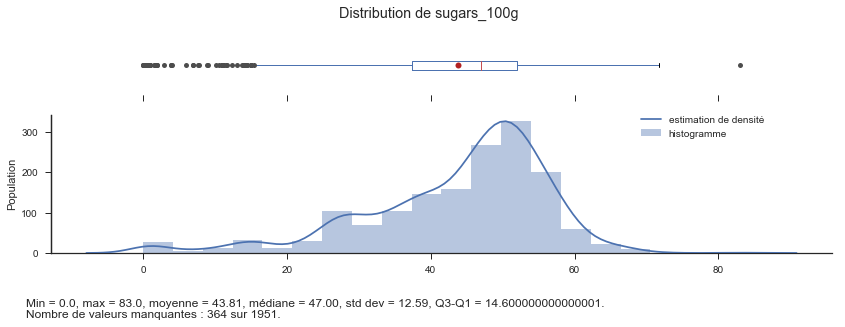

In [37]:
categories = ['en:chocolates']
show_distribution('sugars_100g', categories=categories, bins=20)

Meilleure distribution pour modéliser les données : t


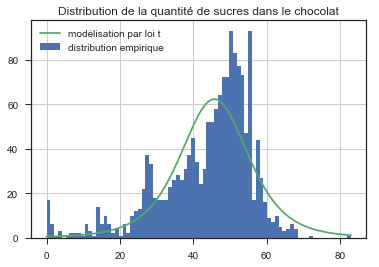

In [38]:
# échantillon à calibrer
mask = data['main_category'].isin(categories) & data['sugars_100g'].notnull()
subset = data.loc[mask, 'sugars_100g']
x = np.linspace(min(subset), max(subset), len(subset))
size = len(subset)
axes = subset.hist(bins=80, label='distribution empirique') 
# calibration
dist_name = select_best_dist(subset)
print(f"Meilleure distribution pour modéliser les données : {dist_name}")
# représentation graphique
dist = getattr(stats, dist_name)
with warnings.catch_warnings():
    warnings.filterwarnings('ignore') # ignore les avertissements de la fonction fit()
    param = dist.fit(subset)
pdf_fitted = dist.pdf(x, *param[:-2], loc=param[-2], scale=param[-1]) * size
axes.plot(x, pdf_fitted, label='modélisation par loi ' + dist_name)
axes.legend();
axes.set_title('Distribution de la quantité de sucres dans le chocolat');

Nous pourrons poursuivre cette modélisation pour un ensemble de catégories et d'indicateurs à déterminer en fonction des objectifs du client.

### Corrélations entre attributs

25836 produits utilisées pour ce calcul.


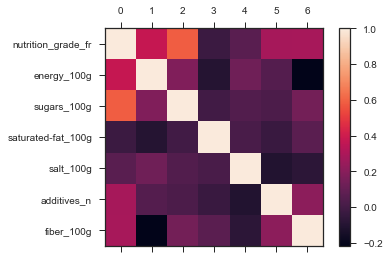

In [39]:
columns = ['nutrition_grade_fr', 'energy_100g', 'sugars_100g', 'saturated-fat_100g', 
           'salt_100g', 'additives_n', 'fiber_100g', 'proteins_100g']
data_partial = data[columns].dropna()
print(f"{len(data_partial)} produits utilisées pour ce calcul.")
corr = data_partial.corr()
fig, axes = plt.subplots(1, 1)
pos = axes.matshow(corr);
axes.set_yticklabels([''] + columns); # le 1er label est ignoré
plt.colorbar(pos);

Les coefficients de corrélation linéaire entre Nutri-score et respectivement quantité d'énergie et quantité de graisses saturées sont supérieurs à 0,5.
Nous calculons les valeurs p associées pour confirmer que ces résultats sont significatifs.

In [42]:
rules = {'Inconnu':0, 'A':1, 'B':2, 'C':3, 'D':4, 'E':5}
data_partial['nutrition_grade_fr'].replace(to_replace=rules, inplace=True)
for col in ['energy_100g', 'saturated-fat_100g']:
    c, p = stats.pearsonr(data_partial['nutrition_grade_fr'], data_partial[col])
    print(f"Corrélation entre Nutri-score et {col} = {c:0.2f}, valeur p = {p}")

Corrélation entre Nutri-score et energy_100g = 0.50, valeur p = 0.0
Corrélation entre Nutri-score et saturated-fat_100g = 0.56, valeur p = 0.0


Il y a une corrélation positive, relativement forte et statistiquement significative entre Nutri-score d'une part, et quantités d'énergie et de graisses saturées d'autre part. On pourra donc utiliser ces 2 dernières variables comme proxy lorsque le Nutri-score n'est pas disponible.